In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
#from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [32]:
df = pd.read_csv('F:\FTLM\capstone project\Combined Data.csv', index_col=0)

In [33]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [35]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [37]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [38]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [39]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

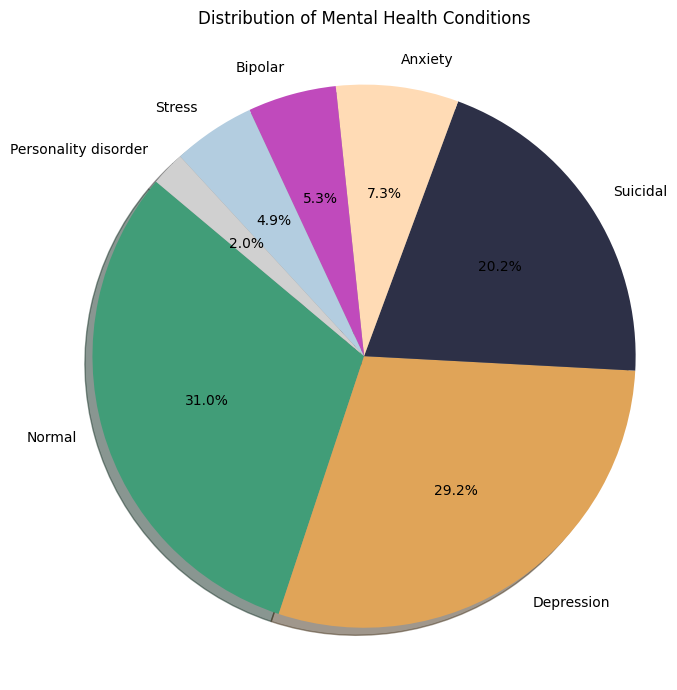

In [40]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [41]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=2).iloc[1])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: I'm upset restless languishing

Status: Bipolar
Statement: Med question Best antidepressant that eases social anxiety but doesn’t send you into a mixed episode? I should add that I am on Rexulti to help combat the side effects of any antidepressants. Cheers!

Status: Depression
Statement: I have depression and anxiety, and have attempted suicide multiple times in the past. I can tell that I am starting to go back to that place and i sorta just want to end it all. Stop this cycle and just sleep, my mom does not help and she does not even know she keeps hurting me. I can even think about my life without me starting to go back the rabbit hole thay is my mind. When someone "helps" its just them saying i should just be happy and I am so lucky for what i have. My home life is not horrible but that does not mean its good. I just want somone that i can talk to that will listen. I do not know what to do

Status: Normal
Statement: morning folk 00 am yawn up amp away to

In [42]:
nltk.download('punkt_tab')

# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PKK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [43]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [44]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [45]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [46]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [47]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


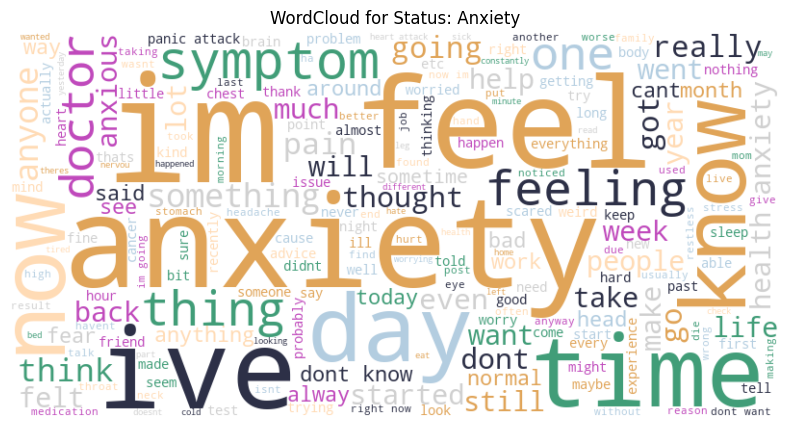

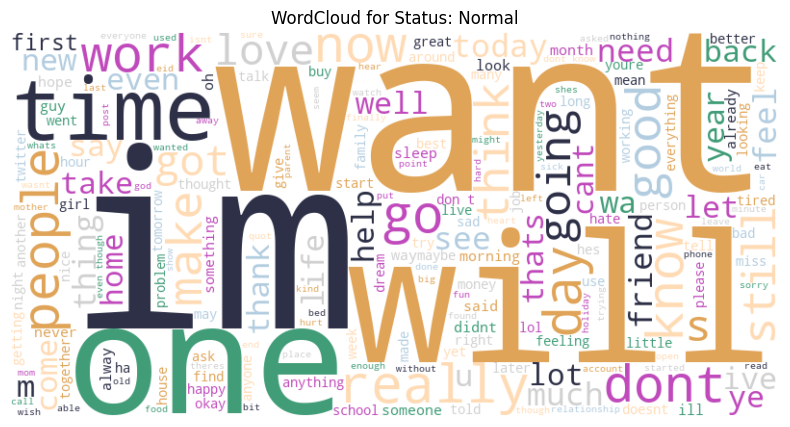

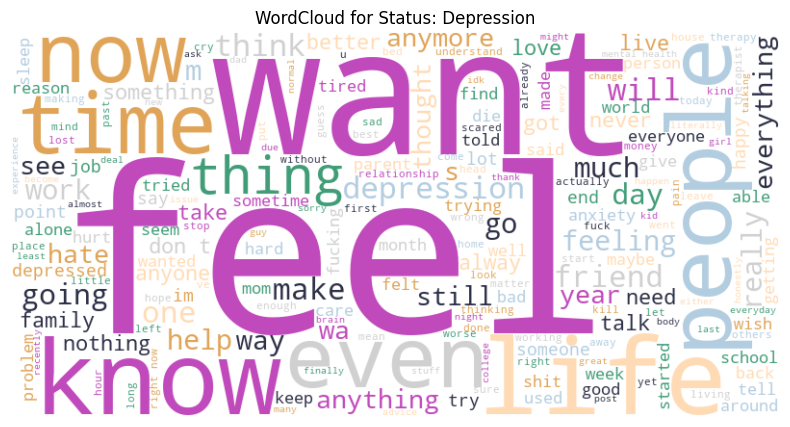

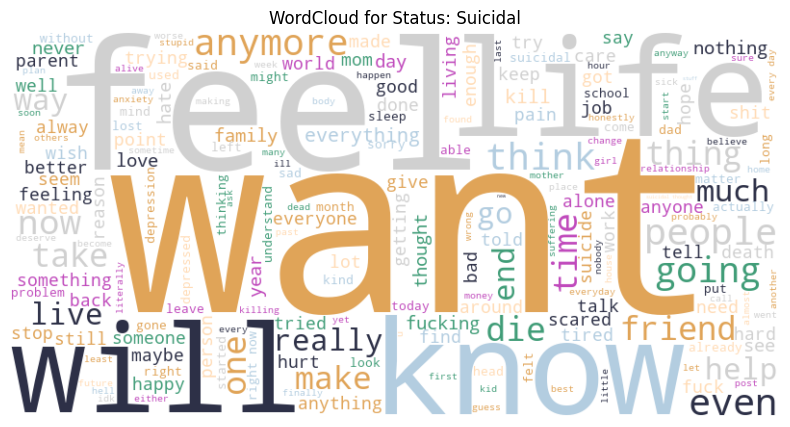

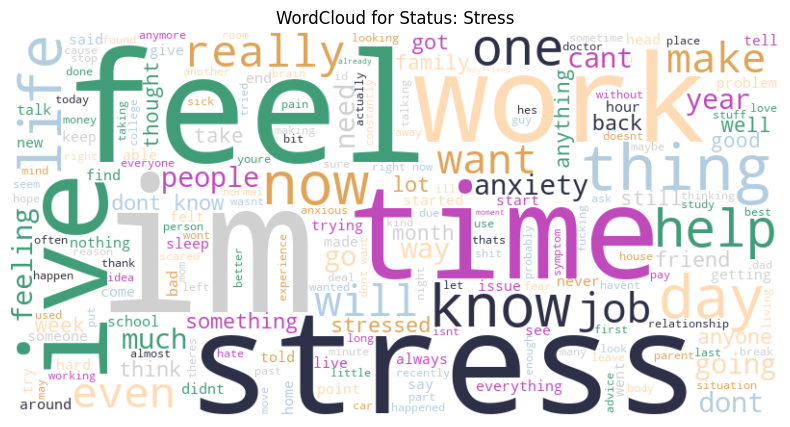

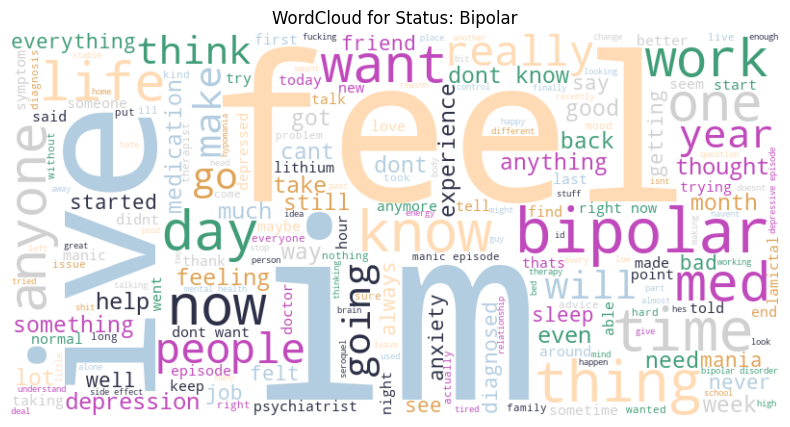

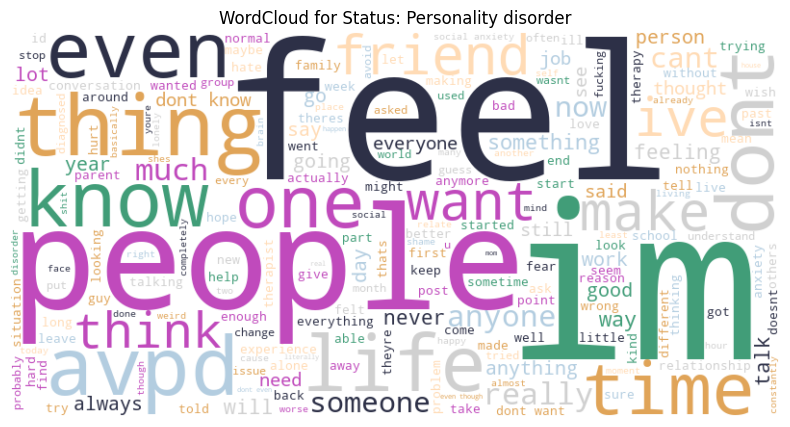

In [49]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

# Data Preprocessing

In [17]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [18]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [20]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [50]:
X_train_combined.shape

(42144, 50002)

# Model training

In [29]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Encode Target Labels
# The original label encoder 'lbl_enc' from cell '_CBbSEIO85ia' already encoded 'y'
# into integer labels, and its 'classes_' attribute holds the original string labels.
# y_train and y_test are already encoded as integers.
print("Using pre-encoded labels...")
y_train_encoded = y_train # y_train is already integer encoded from previous steps
y_test_encoded = y_test   # y_test is already integer encoded from previous steps

# Assuming lbl_enc from cell '_CBbSEIO85ia' is still available and correctly fitted on original string labels.
# lbl_enc.classes_ will contain the original string labels.
print(f"Target classes (from original encoder): {lbl_enc.classes_}")

# 2. Define the models (as imported in your notebook's first cell)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Train the model on the combined TF-IDF features
    model.fit(X_train_combined, y_train_encoded)

    # Make predictions on the test set
    y_pred = model.predict(X_test_combined)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    # We use target_names=lbl_enc.classes_ to see the original status labels
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=lbl_enc.classes_))

    print("-" * (20 + len(name)))

Using pre-encoded labels...
Target classes (from original encoder): ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']

--- Training Logistic Regression ---
Accuracy: 0.5199
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.00      0.00      0.00       768
             Bipolar       0.16      0.01      0.01       566
          Depression       0.41      0.62      0.49      3050
              Normal       0.66      0.91      0.76      3237
Personality disorder       0.14      0.00      0.01       202
              Stress       0.00      0.00      0.00       530
            Suicidal       0.45      0.29      0.35      2184

            accuracy                           0.52     10537
           macro avg       0.26      0.26      0.23     10537
        weighted avg       0.43      0.52      0.45     10537

---------------------------------------

--- Training Bernoulli Naive Bayes ---
A

In [52]:
# 1. Install necessary libraries
!pip install transformers datasets scikit-learn -q

import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- 2. Load and Prepare Data (using 'df' from your notebook) ---

# Ensure 'df' is defined and has the preprocessed 'statement' and 'status' columns
# (This code assumes 'df' is already loaded and cleaned as in your cells 3-8 and 30)
if 'df' not in locals() or 'statement' not in df.columns:
    print("Loading and preprocessing data as per the notebook...")
    df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)
    df.dropna(inplace = True)
    # Apply the same preprocessing from cell 30
    df['statement'] = df['statement'].str.lower()
    df['statement'] = df['statement'].str.replace(r'http[s]?://\S+', '', regex=True)
    df['statement'] = df['statement'].str.replace(r'\[.*?\]\\(.*?\\)', '', regex=True)
    df['statement'] = df['statement'].str.replace(r'@\\w+', '', regex=True)
    df['statement'] = df['statement'].str.replace(r'[^\w\s]', '', regex=True)
    df['statement'] = df['statement'].str.strip()

# BERT needs numeric labels. We map 'status' to 'label'
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])
num_labels = len(le.classes_)

# We'll use 'statement' as 'text'
df_bert = df[['statement', 'label']].rename(columns={'statement': 'text'})

# --- 3. Create Train/Test/Validation Split ---
# We'll split the data into 80% train, 10% validation, 10% test
train_df, test_df = train_test_split(df_bert, test_size=0.2, random_state=42, stratify=df_bert['label'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42, stratify=train_df['label']) # 0.125 * 0.8 = 0.1

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# --- 4. Convert to Hugging Face Dataset object ---
ds = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

# --- 5. Tokenization ---
print("Loading DistilBERT tokenizer...")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # Truncate to the model's max input size (512, but 128 is faster)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

print("Tokenizing datasets...")
tokenized_datasets = ds.map(tokenize_function, batched=True)

# Clean up columns for the Trainer
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"]) # Corrected column name
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# --- 6. Define Model and Metrics ---
print("Loading DistilBERT model...")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

# --- 7. Set Training Arguments ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Evaluate after each epoch (changed from evaluation_strategy)
    num_train_epochs=2,          # 2-3 epochs is standard for fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model at the end
    metric_for_best_model="accuracy",
)

# --- 8. Initialize Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# --- 9. Train the Model ---
print("Starting BERT fine-tuning...")
trainer.train()
print("Training complete!")

# --- 10. Evaluate on Test Set ---
print("\nEvaluating on the test set...")
test_results = trainer.evaluate(tokenized_datasets["test"])

print("\nTest Set Results:")
print(test_results)

# Print classification report with original labels
print("\nTest Classification Report:")
test_preds = trainer.predict(tokenized_datasets["test"])
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=le.classes_))


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Training samples: 36876
Validation samples: 5268
Test samples: 10537
Loading DistilBERT tokenizer...
Tokenizing datasets...


Map:   0%|          | 0/36876 [00:00<?, ? examples/s]

Map:   0%|          | 0/5268 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

##Model Saving Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in your Drive to store the models
# (You only need to run the !mkdir line once, ever)
!mkdir -p "/content/drive/MyDrive/NLP_Models/"

# This is the path we will save everything to
save_path = "/content/drive/MyDrive/NLP_Models/"

In [ ]:
import joblib

# --- 1. Save the Preprocessors ---
print("Saving preprocessors...")
joblib.dump(le, save_path + 'label_encoder.joblib')
joblib.dump(vectorizer, save_path + 'tfidf_statement_vectorizer.joblib')
print("Preprocessors saved to Google Drive.")

# --- 2. Save the Trained Models ---
print("Saving models...")
for name, model in models.items():
    model_filename = f"sklearn_{name.replace(' ', '_')}.joblib"
    joblib.dump(model, save_path + model_filename)
    print(f"Saved {name} to {model_filename}")

print("All scikit-learn models saved to Google Drive!")

In [ ]:
import joblib
import pandas as pd
from scipy.sparse import hstack

# --- 1. Load the Preprocessors ---
print("Loading preprocessors...")
save_path = "/content/drive/MyDrive/NLP_Models/"
le = joblib.load(save_path + 'label_encoder.joblib')
vectorizer = joblib.load(save_path + 'tfidf_statement_vectorizer.joblib')
print("Preprocessors loaded.")

# --- 2. Load Your Chosen Model ---
print("Loading model...")
model_name = "sklearn_XGBoost.joblib" # Let's load the best performing scikit-learn model
loaded_model = joblib.load(save_path + model_name)
print(f"Model {model_name} loaded.")

# --- 3. Now you can use it to predict ---

# Example: Create some new data for prediction
new_statements = [
    "I feel a great sense of peace and happiness today.",
    "I am really struggling with severe anxiety and cannot focus.",
    "Sometimes I feel sad, but it passes quickly."
]

# For numerical features, we'll need to compute them for the new statements
# Based on the original notebook, these were 'num_of_characters' and 'num_of_sentences'
# For a real prediction scenario, these would come from the new input text.
# Here, we'll simulate them or use dummy values for demonstration.

# Preprocess the new statements (same steps as training data)
def remove_patterns(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

processed_statements = [remove_patterns(s) for s in new_statements]
tokenized_statements = [word_tokenize(s) for s in processed_statements]
stemmed_statements = [stem_tokens(t) for t in tokenized_statements]

# Calculate numerical features for new statements
num_of_characters = [len(s) for s in new_statements]
num_of_sentences = [len(nltk.sent_tokenize(s)) for s in new_statements]

# Transform the new data using the *loaded* vectorizer
X_new_tfidf = vectorizer.transform(stemmed_statements)
X_new_num = pd.DataFrame({
    'num_of_characters': num_of_characters,
    'num_of_sentences': num_of_sentences
}).values

X_new_combined = hstack([X_new_tfidf, X_new_num])

# Make predictions with the *loaded* model
predictions = loaded_model.predict(X_new_combined)
decoded_predictions = le.inverse_transform(predictions) # Use loaded label encoder

print("\nNew Statements and Predictions:")
for i, statement in enumerate(new_statements):
    print(f"Statement: '{statement}'")
    print(f"Predicted Status: {decoded_predictions[i]}\n")


In [ ]:
# The only change is the output_dir
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_Models/BERT_model/",  # <-- CHANGE THIS
    eval_strategy="epoch", # Evaluate after each epoch (changed from evaluation_strategy)
    num_train_epochs=2,          # 2-3 epochs is standard for fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model at the end
    metric_for_best_model="accuracy",
)

# ... (rest of the Trainer setup) ...

# After trainer.train() finishes, the best model is saved.
# We'll add one more command to save the final model and tokenizer explicitly.
print("Saving final BERT model and tokenizer to Google Drive...")
trainer.save_model("/content/drive/MyDrive/NLP_Models/BERT_model/final_best/")
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Models/BERT_model/final_best/")
print("BERT model saved.")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_path = "/content/drive/MyDrive/NLP_Models/BERT_model/final_best/"

# --- 1. Load Model and Tokenizer ---
print("Loading BERT model from Google Drive...")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("BERT model loaded.")

# --- 2. Make Predictions ---

# Option A: Use a high-level "pipeline" for easy predictions
print("Creating prediction pipeline...")
# 'device=0' moves the model to the GPU for fast inference
nlp_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

# Now you can feed it raw text
new_text = "i feel so anxious about my exam tomorrow"
result = nlp_pipeline(new_text)
print(f"Prediction: {result}")

# Or predict on a list
new_texts = ["I feel great today!", "I am not feeling like myself."]
results = nlp_pipeline(new_texts)
print(f"Predictions: {results}")

# Option B: Manual prediction (just like in training)
# (This is more complex but gives you the raw outputs)
#
# inputs = tokenizer(new_text, return_tensors="pt", padding=True, truncation=True)
# outputs = model(**inputs)
# logits = outputs.logits
# predicted_class_id = torch.argmax(logits, dim=1).item()
#
# (You'd need to load your LabelEncoder to know what 'predicted_class_id' means)

In [ ]:
import joblib
from scipy.sparse import hstack
from google.colab import drive

# --- 1. Mount Google Drive to access saved files ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

# --- 2. Define File Paths and Sample Data ---
save_path = "/content/drive/MyDrive/NLP_Models/"
model_to_load = "sklearn_Logistic_Regression.joblib"

# Sample data from Step 1
sample_statements = [
    "I can't stop worrying about the future, it feels so overwhelming.",
    "Feeling really productive and happy with how my day went!",
    "I'm just sitting here thinking about everything.",
    "Nothing feels right anymore and I don't see the point.",
    "I'm tired of trying so hard all the time, it's exhausting."
]
sample_titles = [
    "Overwhelming Anxiety",
    "A Great Day",
    "Just Thinking",
    "Feeling Hopeless",
    "Completely Drained"
]

# --- 3. Load the Preprocessors and Model ---
print("\nLoading preprocessors and model from Google Drive...")
try:
    # Load the tools that convert text to numbers
    le = joblib.load(save_path + 'label_encoder.joblib')
    statement_vectorizer = joblib.load(save_path + 'tfidf_statement_vectorizer.joblib')
    title_vectorizer = joblib.load(save_path + 'tfidf_title_vectorizer.joblib')

    # Load the trained model
    model = joblib.load(save_path + model_to_load)

    print("All files loaded successfully.")
    print(f"Model ready. Classes it can predict: {le.classes_}")

except FileNotFoundError:
    print("---")
    print("ERROR: Could not find the saved model or preprocessor files.")
    print(f"Please make sure the files exist in this folder: {save_path}")
    print("---")
    # Stop execution if files aren't found
    exit()

# --- 4. Prepare and Transform the New Data ---
print("\nPreparing and transforming sample data...")
# The vectorizers expect a list of strings.
# We must use the *exact same* vectorizers that we used for training.
sample_statements_vec = statement_vectorizer.transform(sample_statements)
sample_titles_vec = title_vectorizer.transform(sample_titles)

# Combine them in the same way we did during training
sample_combined_vec = hstack([sample_statements_vec, sample_titles_vec])

print(f"Data transformed into shape: {sample_combined_vec.shape}")

# --- 5. Make Predictions ---
print("\nMaking predictions on the sample data...")
# Use the loaded model to predict on the transformed data
predicted_labels_numeric = model.predict(sample_combined_vec)

# --- 6. Decode and Display Results ---
# The model outputs numbers (e.g., 0, 1, 2).
# We use the label encoder to turn these back into words (e.g., 'depressed', 'normal').
predicted_labels_text = le.inverse_transform(predicted_labels_numeric)

print("\n--- Prediction Results ---")
for i in range(len(sample_statements)):
    print(f"Statement: '{sample_statements[i]}'")
    print(f"Predicted Feeling: **{predicted_labels_text[i]}**")
    print("-" * 25)

In [ ]:
import torch

# 1. The most important check: Is CUDA (the NVIDIA GPU) available?
is_available = torch.cuda.is_available()

print(f"Is GPU available?  {is_available}")
print("---")

# 2. If it is available, let's get some details
if is_available:
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
else:
    print("PyTorch cannot find a compatible GPU.")
    print("The model will run on the CPU (this will be very slow for BERT).")

In [ ]:
##Model Saving Local

In [24]:
import joblib
import os

# --- 1. Create a folder to store the models ---
save_directory = "my_saved_models"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
print(f"Models will be saved in: {save_directory}/")

# --- 2. Save the Preprocessors ---
joblib.dump(vectorizer, os.path.join(save_directory, 'tfidf_statement_vectorizer.joblib'))
# joblib.dump(title_vectorizer, os.path.join(save_directory, 'tfidf_title_vectorizer.joblib')) #<-- COMMENTED OUT
joblib.dump(le, os.path.join(save_directory, 'label_encoder.joblib'))
print("Preprocessors saved successfully.")


# --- 3. Save the Trained Models ---
for name, model in models.items():
    model_filename = f"sklearn_{name.replace(' ', '_')}.joblib"
    joblib.dump(model, os.path.join(save_directory, model_filename))
    print(f"Saved: {name}")

print("All scikit-learn models saved successfully.")

Models will be saved in: my_saved_models/
Make sure they are defined and trained.
Saved: Logistic Regression
Saved: Bernoulli Naive Bayes
Saved: Decision Tree
Saved: XGBoost
All scikit-learn models saved successfully.


In [25]:
# --- 1. Define where to save the BERT model ---
bert_save_directory = "my_saved_bert_model"
print(f"Saving BERT model to: {bert_save_directory}/")

# --- 2. Save the Model and Tokenizer ---
# (Assuming your trainer is named 'trainer' and tokenizer is 'tokenizer')
try:
    # The trainer holds the best version of the model
    trainer.save_model(bert_save_directory)
    
    # Also save the tokenizer so you can preprocess new text the same way
    tokenizer.save_pretrained(bert_save_directory)
    
    print("BERT model and tokenizer saved successfully.")
except NameError:
    print("Warning: Could not find 'trainer' or 'tokenizer'.")
    print("Make sure your BERT model has been trained.")

Saving BERT model to: my_saved_bert_model/
Make sure your BERT model has been trained.


In [ ]:
##load model

In [27]:
import joblib
import os
from scipy.sparse import hstack

# --- 1. Load all the pieces ---
save_directory = "my_saved_models"
vectorizer = joblib.load(os.path.join(save_directory, 'tfidf_statement_vectorizer.joblib'))
# title_vectorizer = joblib.load(os.path.join(save_directory, 'tfidf_title_vectorizer.joblib')) #<-- COMMENTED OUT
le = joblib.load(os.path.join(save_directory, 'label_encoder.joblib'))

# --- 2. Load your chosen model (e.g., Logistic Regression) ---
model = joblib.load(os.path.join(save_directory, 'sklearn_Logistic_Regression.joblib'))

print("Model and all preprocessors loaded successfully.")

# --- 3. Now you can predict on new, raw text ---
# (You only need new_statements, not new_titles)
new_statements = ["I feel very anxious today", "I had a great day"]

# Transform using ONLY the one loaded vectorizer
statements_vec = vectorizer.transform(new_statements)
# combined_vec = hstack([statements_vec, titles_vec]) #<-- We don't need to hstack

# Predict using the loaded model
# We pass 'statements_vec' directly, not 'combined_vec'
pred_numeric = model.predict(statements_vec) 
pred_label = le.inverse_transform(pred_numeric)

print(f"Predictions: {pred_label}")

FileNotFoundError: [Errno 2] No such file or directory: 'my_saved_models\\label_encoder.joblib'

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# 1. Load the model and tokenizer from the folder
bert_save_directory = "my_saved_bert_model"
model = AutoModelForSequenceClassification.from_pretrained(bert_save_directory)
tokenizer = AutoTokenizer.from_pretrained(bert_save_directory)

print("BERT model and tokenizer loaded.")

# 2. Use the 'pipeline' for easy predictions
# (device=0 uses GPU, device=-1 uses CPU)
nlp_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

# 3. Predict on new, raw text
new_text = "I am not feeling like myself today."
result = nlp_pipeline(new_text)
print(result)